In [135]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, UnidentifiedImageError

In [136]:
# Define dataset path
train_dir = "/kaggle/input/fruitinamazon/FruitinAmazon/train"
test_dir = "/kaggle/input/fruitinamazon/FruitinAmazon/test"
# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [137]:
corrupted_images = [] # List to store corrupted images path

# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it's a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [138]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class

# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)# for random image selection

selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg'
    , '.jpeg'))]

    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [139]:
# for random image selection

selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg'
    , '.jpeg'))]

    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

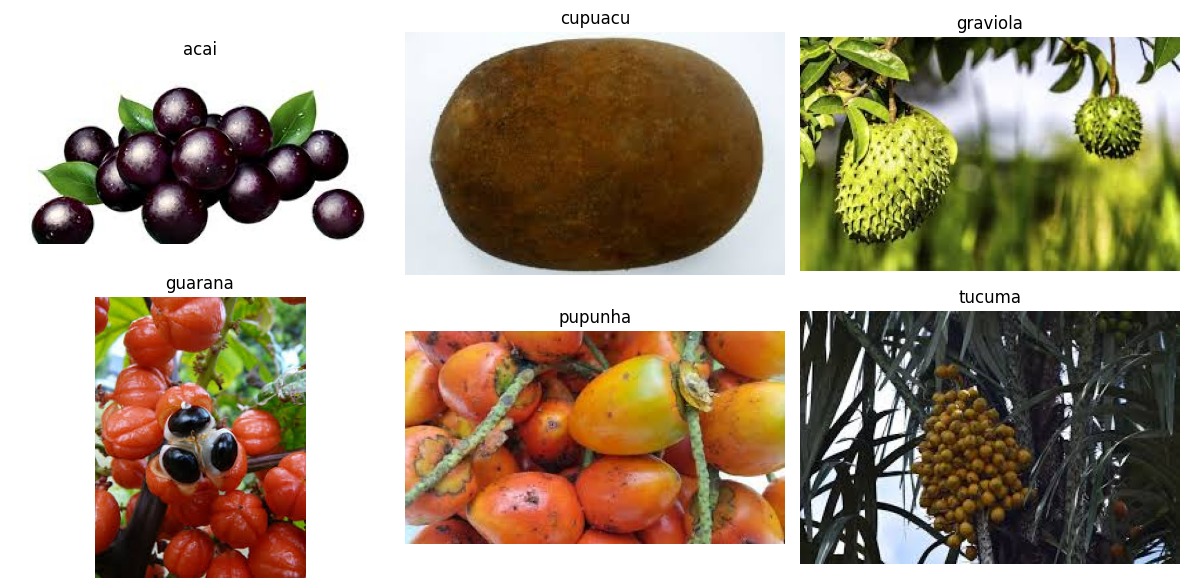

In [140]:
# for random image plot

# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots
plt.tight_layout()
plt.show()

In [141]:
image_size = (32, 32)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [142]:
# To check the shape of a batch

for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 32, 32, 3)
Labels shape: (32,)


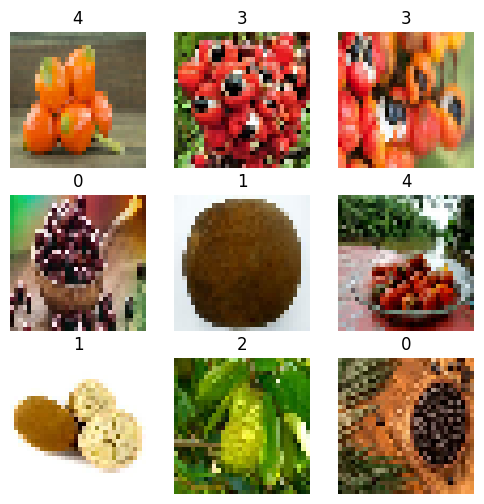

In [143]:
# Visualizing training dataset

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1): #Takes one batch of images from the dataset (train_ds).
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [144]:
# Using Keras tf.keras.layers.Random (New API):

data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.5),
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.2)
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [145]:
# DataAugemntation Layer directly in Model

model = keras.Sequential([
  layers.Input(shape=(128, 128, 3)),
  *data_augmentation_layers, # Include augmentation before the model layers

  layers.Conv2D(32, (3,3), activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

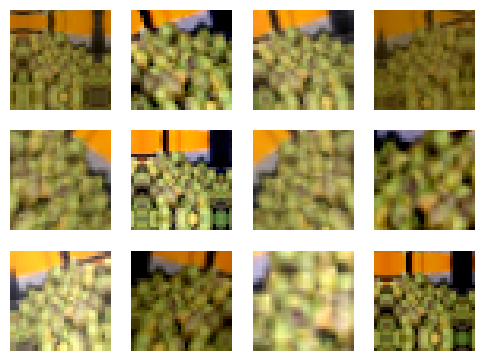

In [146]:
# Visualizing augemented Image.
plt.figure(figsize=(6, 6))
for images, _ in train_ds.take(1):
  for i in range(12):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

In [147]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [148]:
# Data augmentation layers
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.5),
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.2)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Define the model using the Sequential API with a list of layers
model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),

    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    Flatten(),

    # First Fully Connected Layer
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Second Fully Connected Layer
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Third Fully Connected Layer
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fourth Fully Connected Layer
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output Layer with 10 neurons (for classification task with 10 classes)
    Dense(10, activation='softmax')
])

In [149]:
# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use this for integer labels
              metrics=['accuracy'])

In [150]:
# Summary of the model
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [151]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))# Freeze the layers of the base model


In [152]:
# Freeze the layers of the base model
for layer in base_model.layers:
  layer.trainable = False

In [153]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-classclassification)

In [154]:
from tensorflow.keras.models import Model
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [155]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [156]:
# Corrected code for generating train and validation datasets
image_size = (32, 32)
batch_size = 32

# Generate training dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Generate validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [157]:
# Compile the model with sparse_categorical_crossentropy
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)


# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1667 - loss: 21.1361 - val_accuracy: 0.1111 - val_loss: 21.0531
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.6736 - loss: 6.6060 - val_accuracy: 0.3333 - val_loss: 16.0286
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.8780 - loss: 0.6754 - val_accuracy: 0.5000 - val_loss: 21.6343
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.9744 - loss: 0.3188 - val_accuracy: 0.3889 - val_loss: 24.7582
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.3333 - val_loss: 25.0812
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.9518 - loss: 0.2836 - val_accuracy: 0.3889 - val_loss: 26.0970
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.9891 - loss: 0.0647 - val_accuracy: 0.3889 - val_loss: 26.2554


In [158]:
# 2. Generate Inference Output
# Generate predictions for the validation dataset
val_images, val_labels = next(iter(val_ds))
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted and actual labels
print("Predicted classes:", predicted_classes)
print("Actual labels:", val_labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Predicted classes: [4 3 0 5 4 1 0 4 5 5 5 4 4 1 0 4 0 3]
Actual labels: [4 2 0 5 5 0 4 4 1 4 0 1 1 1 5 5 5 3]


In [159]:
from sklearn.metrics import classification_report

# Generate the classification report
print("\nClassification Report:")
print(classification_report(val_labels.numpy(), predicted_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        acai       0.25      0.33      0.29         3
     cupuacu       0.50      0.25      0.33         4
    graviola       0.00      0.00      0.00         1
     guarana       0.50      1.00      0.67         1
     pupunha       0.33      0.50      0.40         4
      tucuma       0.25      0.20      0.22         5

    accuracy                           0.33        18
   macro avg       0.31      0.38      0.32        18
weighted avg       0.32      0.33      0.31        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


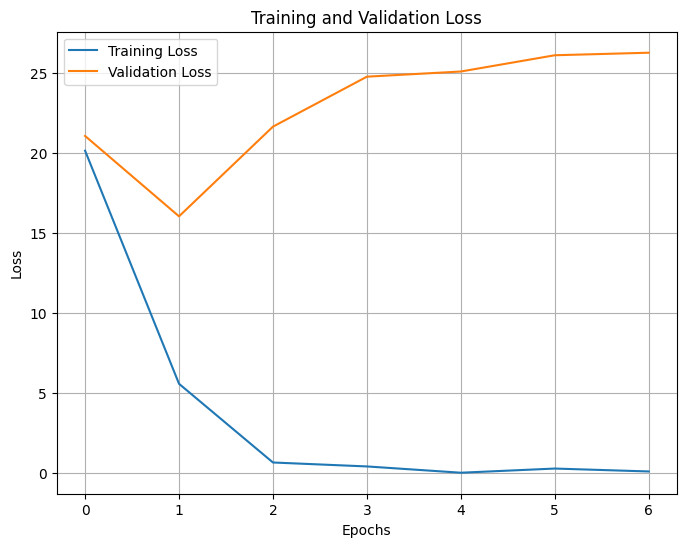

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()